<a href="https://colab.research.google.com/github/hsinjlee/Deep_Learning/blob/main/Convolutional%20Neural%20Network/CNN_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Convolutional Neural Network from Scratch
* 2 Convolution Layers (followed by Relu)
* 2 Max Pooling Layers
* 3 Fully Connected Layers

**1. Define the CNN Architecture**

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
#Define CNN Architecture

class CNN(nn.Module):
    def __init__(self):
        # Initialize the class as a subclass of nn.Module
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels, 6 output channels, 5x5 kernel

        # First max pooling layer
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # Second convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 output channels, 5x5 kernel

        # Second max pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2

        # 3 Fully connected layers
        # Linear transformation to 120-dimensional space
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Flattening the input, 16*5*5 input features, 120 output features

        # Linear transformation to 84-dimensional space
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features

        # Linear transformation to 10-dimensional space (output classes)
        self.fc3 = nn.Linear(84, 10)  # 84 input features, 10 output features (number of classes)

    def forward(self, x):
        # Operation 1: First convolutional layer with ReLU activation and max pooling
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Operation 2: Second convolutional layer with ReLU activation and max pooling
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Operation 3: Flattened Layer: Reshape for fully connected layer
        x = x.view(-1, 16 * 5 * 5)

        # Operation 4: First fully connected layer with ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Operation 5: Second fully connected layer with ReLU activation
        x = self.fc2(x)
        x = F.relu(x)

        # Operation 6: Output layer (fully connected) with raw scores for each class
        x = self.fc3(x)

        return x



In [5]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
from torchsummary import summary
summary(model, (3, 32, 32))  # Input shape: (channels, height, width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


**2. CIFAR10 Image Dataset and its Augmentation**

https://www.cs.toronto.edu/~kriz/cifar.html








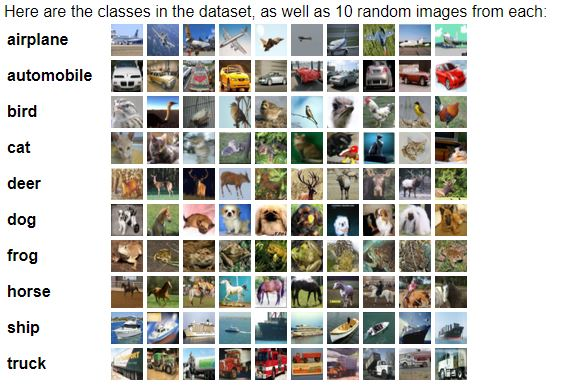

In [7]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

# Define the data transform for Data Augmentation
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(1.0,1.0)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
# Load the data
#Training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True, num_workers=2)

#Test Data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

#CIFAR-10 CLASSES
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 51.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
# Print the lengths of the trainset and testset
print("Trainset length:", len(trainset))
print("Testset length:", len(testset))

Trainset length: 50000
Testset length: 10000


**3. HyperParameters Optimazation**

In [10]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the  optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

**4. CNN Training**

In [11]:
# Training loop
for epoch in range(10):
    train_loss = 0  # Initialize training loss accumulator for the epoch
    train_acc = 0   # Initialize training accuracy accumulator for the epoch

    model.train()   # Set the model to training mode

    # Iterate over the training data loader
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()   # Clear previously calculated gradients

        outputs = model(inputs)   # Forward pass: compute model predictions
        loss = criterion(outputs, labels)   # Compute the loss between model predictions and ground truth labels
        loss.backward()   # Backward pass: compute gradients of loss w.r.t. model parameters
        optimizer.step()   # Update model parameters using the optimizer

        train_loss += loss.item()   # Accumulate the training loss for the current batch

        # Calculate the training accuracy for the current batch
        _, preds = torch.max(outputs, 1)   # Get the predicted class labels
        train_acc += (preds == labels).float().mean()   # Compute accuracy by comparing predictions with true labels

    train_loss /= i + 1   # Calculate average training loss for the epoch
    train_acc /= i + 1   # Calculate average training accuracy for the epoch

    # Print epoch-wise training loss and accuracy
    print('Epoch {}: Train Loss: {:.4f}, Train Acc: {:.4f}'.format(epoch + 1, train_loss, train_acc))


Epoch 1: Train Loss: 1.5674, Train Acc: 0.4258
Epoch 2: Train Loss: 1.3523, Train Acc: 0.5140
Epoch 3: Train Loss: 1.2810, Train Acc: 0.5449
Epoch 4: Train Loss: 1.2373, Train Acc: 0.5645
Epoch 5: Train Loss: 1.2067, Train Acc: 0.5776
Epoch 6: Train Loss: 1.1898, Train Acc: 0.5823
Epoch 7: Train Loss: 1.1683, Train Acc: 0.5889
Epoch 8: Train Loss: 1.1603, Train Acc: 0.5954
Epoch 9: Train Loss: 1.1397, Train Acc: 0.6004
Epoch 10: Train Loss: 1.1253, Train Acc: 0.6060


**5. Test Model**

In [12]:
# Validate the model on the Test Set
with torch.no_grad():   # Context manager to disable gradient calculation
    correct = 0   # Initialize variable to count correct predictions
    total = 0   # Initialize variable to count total number of samples
    for images, labels in testloader:   # Iterate over the test loader
        outputs = model(images)   # Forward pass: compute model predictions
        _, predicted = torch.max(outputs.data, 1)   # Get the index of the class with the highest probability
        total += labels.size(0)   # Increment the total count by the batch size
        correct += (predicted == labels).sum().item()   # Count the number of correct predictions in the batch

    # Print the accuracy of the model on the Test Images
    print(f'Accuracy of the network on the validation images: {100 * correct / total} %')

Accuracy of the network on the validation images: 60.16 %


**Calculate the Confusion Matrix, Recall, Precision and F1 Score**

In [13]:
!pip install plotly


In [14]:
from sklearn.metrics import confusion_matrix, classification_report   # Import necessary libraries for evaluation metrics
import plotly.figure_factory as ff   # Import Plotly library for visualization
import numpy as np   # Import NumPy library for numerical operations

# Evaluation loop
model.eval()   # Set the model to evaluation mode
all_preds = []   # Initialize an empty list to store all predictions
all_labels = []   # Initialize an empty list to store all true labels

# Iterate over the test dataset
with torch.no_grad():   # Disable gradient calculation during evaluation
    for inputs, labels in testloader:   # Iterate over batches of test data
        outputs = model(inputs)   # Forward pass: compute model predictions
        _, preds = torch.max(outputs, 1)   # Get the index of the class with the highest probability

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())   # Convert predictions to CPU and append to the list
        all_labels.extend(labels.cpu().numpy())   # Convert labels to CPU and append to the list

# Convert lists to numpy arrays
all_preds = np.array(all_preds)   # Convert the list of predictions to a NumPy array
all_labels = np.array(all_labels)   # Convert the list of true labels to a NumPy array

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds, normalize='true')   # Compute the confusion matrix with normalized values

# Plot confusion matrix using plotly
fig = ff.create_annotated_heatmap(
    z=conf_matrix,   # Data for the heatmap
    x=classes,   # Labels for the x-axis (predicted labels)
    y=classes,   # Labels for the y-axis (true labels)
    colorscale='Viridis',   # Color scale for the heatmap
    showscale=True   # Show the color scale legend
)

# Update layout of the plot
fig.update_layout(
    title_text='Confusion Matrix',   # Set the title of the plot
    xaxis=dict(title='Predicted label'),   # Set the label for the x-axis
    yaxis=dict(title='True label')   # Set the label for the y-axis
)

fig.show()   # Show the plot

# Generate and print the classification report
class_report = classification_report(all_labels, all_preds, target_names=classes)   # Generate the classification report
print("\nClassification Report:")   # Print a title for the classification report
print(class_report)   # Print the classification report



Classification Report:
              precision    recall  f1-score   support

       plane       0.63      0.66      0.64      1000
         car       0.75      0.67      0.71      1000
        bird       0.47      0.54      0.50      1000
         cat       0.50      0.28      0.36      1000
        deer       0.52      0.49      0.51      1000
         dog       0.51      0.54      0.52      1000
        frog       0.63      0.77      0.70      1000
       horse       0.59      0.69      0.64      1000
        ship       0.68      0.76      0.72      1000
       truck       0.73      0.62      0.67      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



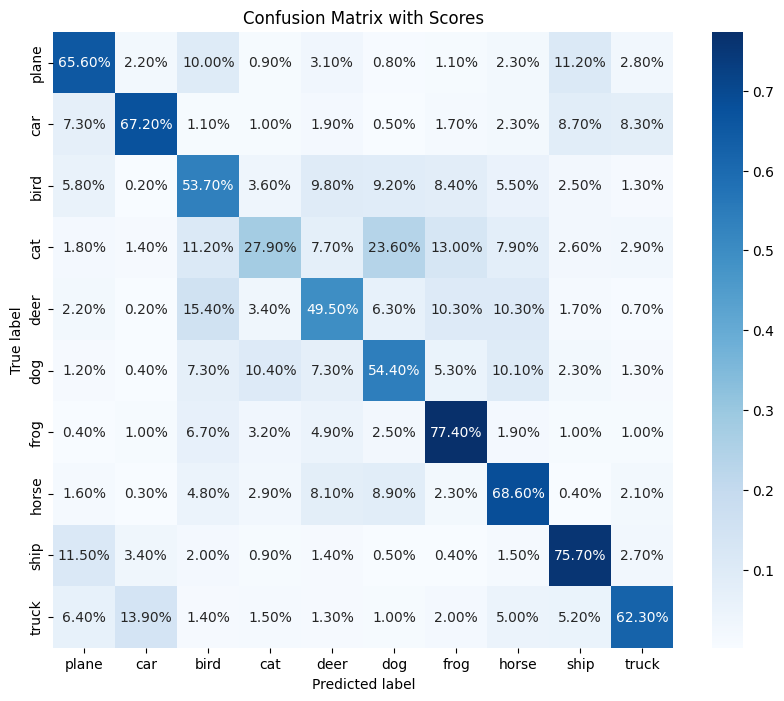

In [15]:
import matplotlib.pyplot as plt   # Import Matplotlib library for visualization
import seaborn as sns   # Import Seaborn library for enhanced visualization
from sklearn.metrics import confusion_matrix   # Import confusion_matrix function from scikit-learn
import numpy as np   # Import NumPy library for numerical operations

# Assuming you have 'all_labels' and 'all_preds' from your previous code

# Create the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)   # Compute the confusion matrix

# Normalize the confusion matrix to show percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]   # Normalize the confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(10, 8))   # Set the size of the plot
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=classes, yticklabels=classes)   # Plot the heatmap
plt.title("Confusion Matrix with Scores")   # Set the title of the plot
plt.xlabel("Predicted label")   # Set the label for the x-axis
plt.ylabel("True label")   # Set the label for the y-axis
plt.show()   # Show the plot
